In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
import pickle
from tqdm import tqdm
from collections import defaultdict

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load the trained model
with open('../../ml_service/app/models/collaborative_filtering/als_model.pkl', 'rb') as f:
    model = pickle.load(f)
print("✓ Loaded trained ALS model")

# Load train matrix (needed for making recommendations)
train_matrix = load_npz('../../ml_service/app/models/collaborative_filtering/train_matrix.npz')
print(f"✓ Loaded train matrix: {train_matrix.shape}")

# Load test matrix (for evaluation)
test_matrix = load_npz('../../ml_service/app/models/collaborative_filtering/test_matrix.npz')
print(f"✓ Loaded test matrix: {test_matrix.shape}")

# Load mappings
user_mapping = pd.read_csv('../../ml_service/app/models/collaborative_filtering/user_mapping.csv', index_col=0)
item_mapping = pd.read_csv('../../ml_service/app/models/collaborative_filtering/item_mapping.csv', index_col=0)
print(f"✓ Loaded user mapping: {len(user_mapping)} users")
print(f"✓ Loaded item mapping: {len(item_mapping)} items")

# Load metadata
with open('../../ml_service/app/models/collaborative_filtering/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
print("✓ Loaded metadata")

print("\n" + "="*50)
print("MODEL INFO")
print("="*50)
print(f"Users: {metadata['n_users']:,}")
print(f"Items: {metadata['n_items']:,}")
print(f"Train size: {metadata['train_size']:,}")
print(f"Test size: {metadata['test_size']:,}")
print(f"Factors: {metadata['factors']}")
print("="*50)

✓ Loaded trained ALS model
✓ Loaded train matrix: (1193, 1350)
✓ Loaded test matrix: (1193, 1350)
✓ Loaded user mapping: 1193 users
✓ Loaded item mapping: 1350 items
✓ Loaded metadata

MODEL INFO
Users: 1,193
Items: 1,350
Train size: 1,171
Test size: 293
Factors: 50


c:\Users\hp\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def precision_at_k(model, train_matrix, test_matrix, k=10, sample_users=None):
    """
    Calculate Precision@K for the model.
    
    Args:
        model: Trained ALS model
        train_matrix: Training interaction matrix
        test_matrix: Test interaction matrix
        k: Number of recommendations to evaluate
        sample_users: Number of users to sample (None = all users)
    
    Returns:
        Average precision@k across all users
    """
    precision_scores = []
    
    # Get users who have test interactions
    test_users = np.unique(test_matrix.nonzero()[0])
    
    # Sample users if specified
    if sample_users and sample_users < len(test_users):
        test_users = np.random.choice(test_users, sample_users, replace=False)
    
    print(f"Evaluating Precision@{k} on {len(test_users)} users...")
    
    for user_id in tqdm(test_users):
        # Get items the user has in test set (ground truth)
        test_items = set(test_matrix[user_id].indices)
        
        # Skip if no test items
        if len(test_items) == 0:
            continue
        
        try:
            # Get top K recommendations
            recommendations = model.recommend(
                user_id,
                train_matrix[user_id],
                N=k,
                filter_already_liked_items=True
            )
            
            # Get recommended item IDs
            recommended_items = set(recommendations[0])
            
            # Calculate precision: how many recommendations were relevant?
            hits = len(recommended_items & test_items)
            precision = hits / k
            precision_scores.append(precision)
            
        except Exception as e:
            # Skip users with errors
            continue
    
    return np.mean(precision_scores) if precision_scores else 0.0


def recall_at_k(model, train_matrix, test_matrix, k=10, sample_users=None):
    """
    Calculate Recall@K for the model.
    
    Args:
        model: Trained ALS model
        train_matrix: Training interaction matrix
        test_matrix: Test interaction matrix
        k: Number of recommendations to evaluate
        sample_users: Number of users to sample (None = all users)
    
    Returns:
        Average recall@k across all users
    """
    recall_scores = []
    
    # Get users who have test interactions
    test_users = np.unique(test_matrix.nonzero()[0])
    
    # Sample users if specified
    if sample_users and sample_users < len(test_users):
        test_users = np.random.choice(test_users, sample_users, replace=False)
    
    print(f"Evaluating Recall@{k} on {len(test_users)} users...")
    
    for user_id in tqdm(test_users):
        # Get items the user has in test set
        test_items = set(test_matrix[user_id].indices)
        
        # Skip if no test items
        if len(test_items) == 0:
            continue
        
        try:
            # Get top K recommendations
            recommendations = model.recommend(
                user_id,
                train_matrix[user_id],
                N=k,
                filter_already_liked_items=True
            )
            
            # Get recommended item IDs
            recommended_items = set(recommendations[0])
            
            # Calculate recall: what fraction of relevant items did we recommend?
            hits = len(recommended_items & test_items)
            recall = hits / len(test_items)
            recall_scores.append(recall)
            
        except Exception as e:
            continue
    
    return np.mean(recall_scores) if recall_scores else 0.0


def calculate_coverage(model, train_matrix, n_items, k=10, sample_users=1000):
    """
    Calculate catalog coverage: what % of items can be recommended?
    
    Args:
        model: Trained model
        train_matrix: Training matrix
        n_items: Total number of items
        k: Number of recommendations per user
        sample_users: Number of users to sample
    
    Returns:
        Coverage percentage (0-100)
    """
    recommended_items = set()
    
    # Sample users
    n_users = train_matrix.shape[0]
    sample_size = min(sample_users, n_users)
    sampled_users = np.random.choice(n_users, sample_size, replace=False)
    
    print(f"Calculating coverage on {sample_size} users...")
    
    for user_id in tqdm(sampled_users):
        try:
            recommendations = model.recommend(
                user_id,
                train_matrix[user_id],
                N=k
            )
            recommended_items.update(recommendations[0])
        except:
            continue
    
    coverage = (len(recommended_items) / n_items) * 100
    return coverage, len(recommended_items)

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [4]:
# Set sample size (reduce if evaluation is too slow)
SAMPLE_USERS = 1000  # Adjust based on your needs

print("Starting evaluation...\n")
results = {}

Starting evaluation...



In [5]:
# Evaluate at different K values
k_values = [5, 10, 20]

for k in k_values:
    print(f"\n{'='*50}")
    print(f"Evaluating at K={k}")
    print(f"{'='*50}")
    
    # Calculate Precision@K
    precision = precision_at_k(model, train_matrix, test_matrix, k=k, sample_users=SAMPLE_USERS)
    print(f"\nPrecision@{k}: {precision:.4f}")
    print(f"  → Out of {k} recommendations, {precision*k:.2f} are relevant on average")
    
    # Calculate Recall@K
    recall = recall_at_k(model, train_matrix, test_matrix, k=k, sample_users=SAMPLE_USERS)
    print(f"\nRecall@{k}: {recall:.4f}")
    print(f"  → We capture {recall*100:.2f}% of relevant items in top {k}")
    
    # Store results
    results[k] = {
        'precision': precision,
        'recall': recall
    }


Evaluating at K=5
Evaluating Precision@5 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4274.41it/s]



Precision@5: 0.0007
  → Out of 5 recommendations, 0.00 are relevant on average
Evaluating Recall@5 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4699.26it/s]



Recall@5: 0.0037
  → We capture 0.37% of relevant items in top 5

Evaluating at K=10
Evaluating Precision@10 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4614.53it/s]



Precision@10: 0.0011
  → Out of 10 recommendations, 0.01 are relevant on average
Evaluating Recall@10 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4810.53it/s]



Recall@10: 0.0110
  → We capture 1.10% of relevant items in top 10

Evaluating at K=20
Evaluating Precision@20 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4616.78it/s]



Precision@20: 0.0005
  → Out of 20 recommendations, 0.01 are relevant on average
Evaluating Recall@20 on 273 users...


100%|██████████| 273/273 [00:00<00:00, 4820.73it/s]


Recall@20: 0.0110
  → We capture 1.10% of relevant items in top 20


In [6]:
# Calculate coverage
print(f"\n{'='*50}")
print("Calculating Coverage")
print(f"{'='*50}")

coverage, n_covered = calculate_coverage(
    model, 
    train_matrix, 
    metadata['n_items'], 
    k=10, 
    sample_users=SAMPLE_USERS
)

print(f"\nCatalog Coverage: {coverage:.2f}%")
print(f"  → Model can recommend {n_covered:,} out of {metadata['n_items']:,} items")

results['coverage'] = coverage


Calculating Coverage
Calculating coverage on 1000 users...


100%|██████████| 1000/1000 [00:00<00:00, 4520.25it/s]


Catalog Coverage: 44.44%
  → Model can recommend 600 out of 1,350 items


C:\Users\hp\AppData\Local\Temp\ipykernel_22728\1553471953.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


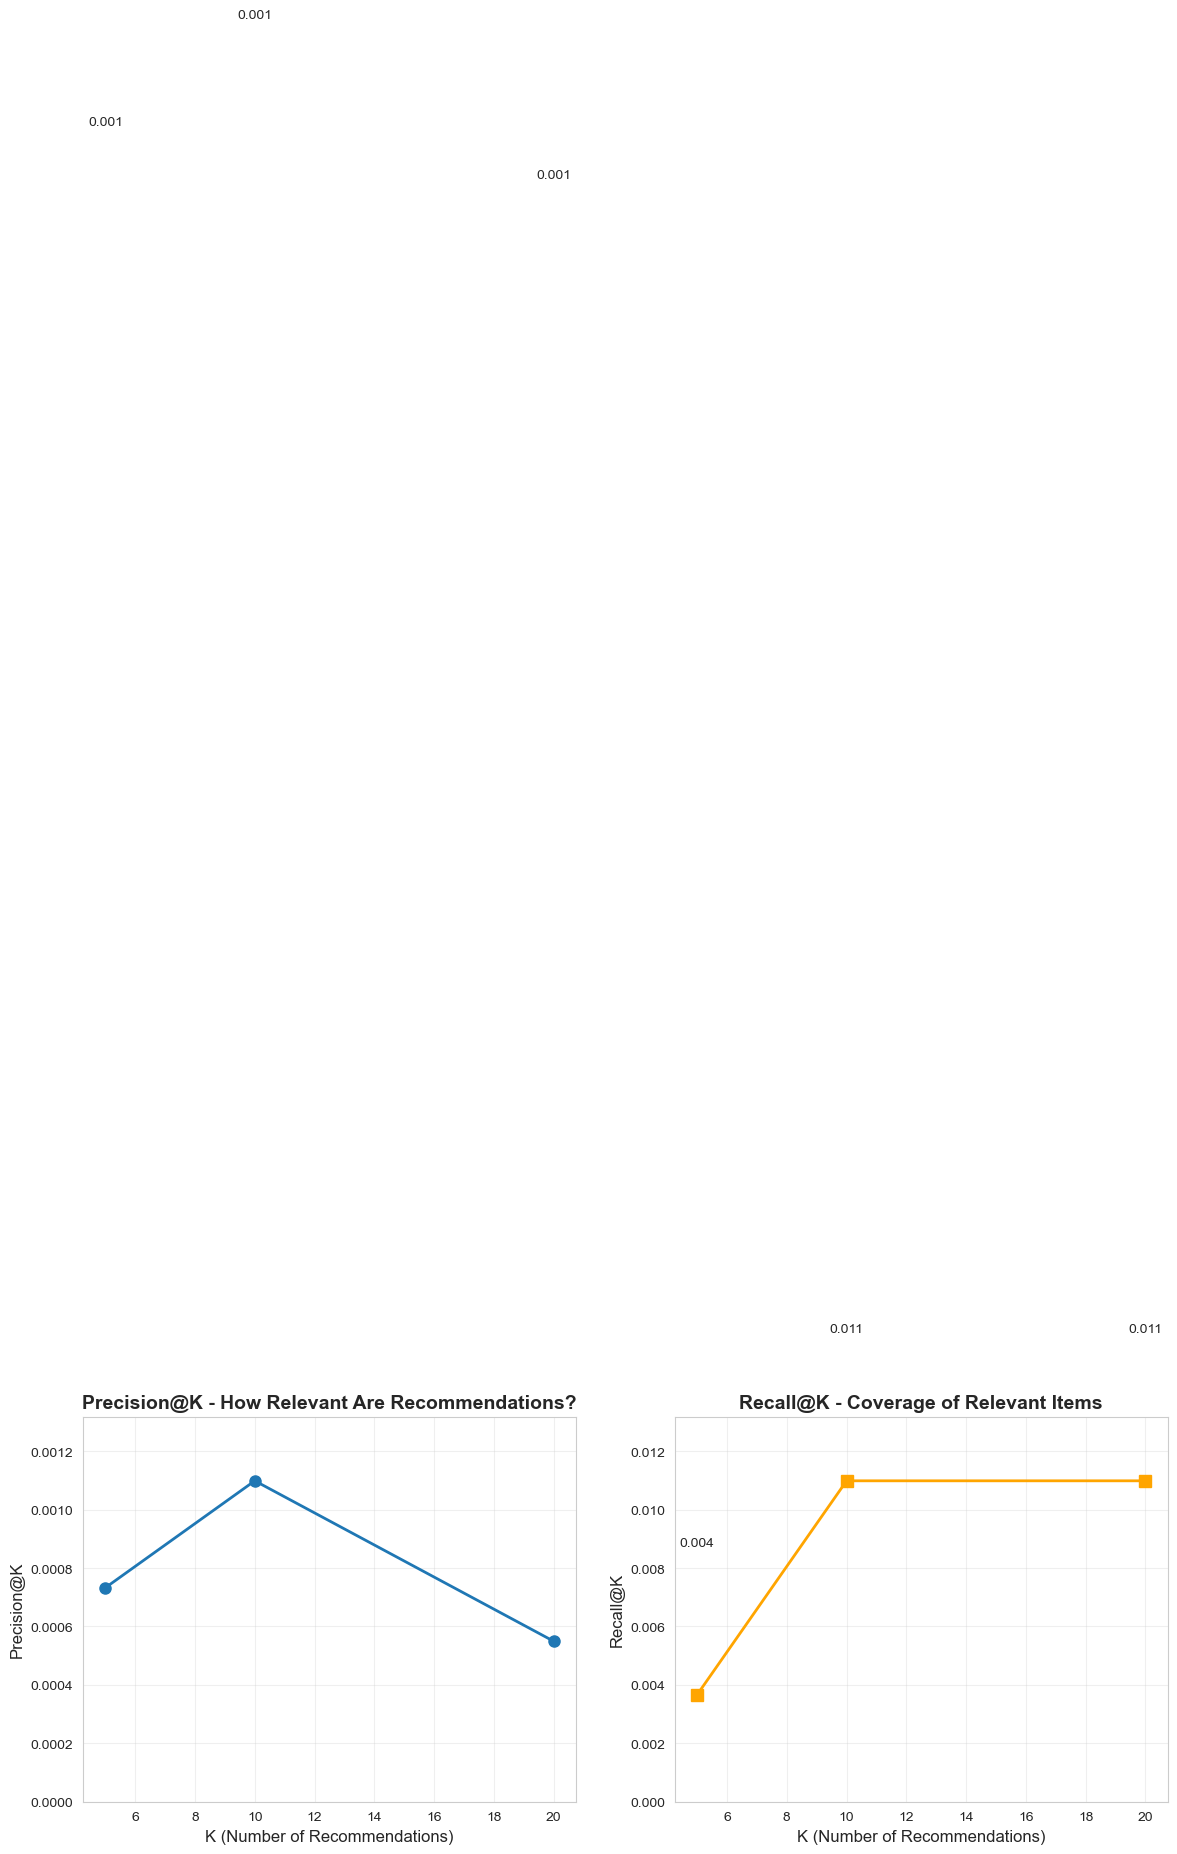

✓ Plot saved: evaluation_metrics.png


In [8]:
# Create results dataframe
results_df = pd.DataFrame([
    {'K': k, 'Metric': 'Precision', 'Value': v['precision']} 
    for k, v in results.items() if k != 'coverage'
] + [
    {'K': k, 'Metric': 'Recall', 'Value': v['recall']} 
    for k, v in results.items() if k != 'coverage'
])

# Plot Precision and Recall at different K values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision@K
precision_data = results_df[results_df['Metric'] == 'Precision']
ax1.plot(precision_data['K'], precision_data['Value'], marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('K (Number of Recommendations)', fontsize=12)
ax1.set_ylabel('Precision@K', fontsize=12)
ax1.set_title('Precision@K - How Relevant Are Recommendations?', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(precision_data['Value']) * 1.2)

# Add value labels
for x, y in zip(precision_data['K'], precision_data['Value']):
    ax1.text(x, y + 0.005, f'{y:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Recall@K
recall_data = results_df[results_df['Metric'] == 'Recall']
ax2.plot(recall_data['K'], recall_data['Value'], marker='s', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('K (Number of Recommendations)', fontsize=12)
ax2.set_ylabel('Recall@K', fontsize=12)
ax2.set_title('Recall@K - Coverage of Relevant Items', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, max(recall_data['Value']) * 1.2)

# Add value labels
for x, y in zip(recall_data['K'], recall_data['Value']):
    ax2.text(x, y + 0.005, f'{y:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../../ml_service/app/models/collaborative_filtering/evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: evaluation_metrics.png")

In [ ]:
# Create comparison table
comparison_df = results_df.pivot(index='K', columns='Metric', values='Value')
comparison_df['F1-Score'] = 2 * (comparison_df['Precision'] * comparison_df['Recall']) / \
                                (comparison_df['Precision'] + comparison_df['Recall'])

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(comparison_df.round(4))
print("="*60)
print(f"\nCatalog Coverage: {coverage:.2f}%")
print("="*60)


EVALUATION SUMMARY
Metric  Precision  Recall  F1-Score
K                                  
5          0.0007  0.0037    0.0012
10         0.0011  0.0110    0.0020
20         0.0005  0.0110    0.0010

Catalog Coverage: 45.19%


In [ ]:
def show_user_recommendations(user_id, k=10):
    """
    Show recommendations for a specific user along with their history.
    """
    print(f"\n{'='*80}")
    print(f"USER {user_id} RECOMMENDATIONS")
    print(f"{'='*80}")
    
    # Get user's training items
    train_items = set(train_matrix[user_id].indices)
    print(f"\nUser has {len(train_items)} items in training set")
    
    # Get user's test items (ground truth)
    test_items = set(test_matrix[user_id].indices)
    print(f"User has {len(test_items)} items in test set (what they actually liked)")
    
    # Get recommendations
    recommendations = model.recommend(
        user_id,
        train_matrix[user_id],
        N=k,
        filter_already_liked_items=True
    )
    
    print(f"\nTop {k} Recommendations:")
    print("-" * 80)
    print(f"{'Rank':<6} {'Product ID':<20} {'Score':<10} {'In Test Set?'}")
    print("-" * 80)
    
    hits = 0
    for rank, (item_id, score) in enumerate(zip(recommendations[0], recommendations[1]), 1):
        product_id = item_mapping.loc[item_id, 'product_id']
        in_test = '✓ HIT' if item_id in test_items else ''
        if in_test:
            hits += 1
        print(f"{rank:<6} {product_id:<20} {score:<10.4f} {in_test}")
    
    print("-" * 80)
    print(f"\nHits: {hits}/{k} = {hits/k*100:.1f}% precision")
    print(f"Recall: {hits}/{len(test_items)} = {hits/len(test_items)*100:.1f}% of relevant items captured")
    print("="*80)

# Show recommendations for 3 random users
test_users = np.unique(test_matrix.nonzero()[0])
sample_users_to_show = np.random.choice(test_users, min(3, len(test_users)), replace=False)

for user_id in sample_users_to_show:
    show_user_recommendations(user_id, k=10)


USER 1192 RECOMMENDATIONS

User has 0 items in training set
User has 1 items in test set (what they actually liked)

Top 10 Recommendations:
--------------------------------------------------------------------------------
Rank   Product ID           Score      In Test Set?
--------------------------------------------------------------------------------
1      B0073QGKAS           0.0000     
2      B006LW0WDQ           0.0000     
3      B005LJQMZC           0.0000     
4      B005LJQMCK           0.0000     
5      B005FYNT3G           0.0000     
6      B004IO5BMQ           0.0000     
7      B003L62T7W           0.0000     
8      B003B00484           0.0000     
9      B002SZEOLG           0.0000     
10     B002PD61Y4           0.0000     
--------------------------------------------------------------------------------

Hits: 0/10 = 0.0% precision
Recall: 0/1 = 0.0% of relevant items captured

USER 293 RECOMMENDATIONS

User has 0 items in training set
User has 1 items in test set